<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [0]:
import os
import time
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

In [2]:
%%time

!git clone -l -s git://github.com/kavyajeetbora/EAST.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 111 (delta 11), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (111/111), 5.73 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/cloned-repo
dataset.py  dsiplay_ground_truth.ipynb	EAST_resnet.py	     loss.py   train.py
detect.py   EAST_detection.ipynb	EAST_training.ipynb  model.py
CPU times: user 130 ms, sys: 18.2 ms, total: 148 ms
Wall time: 12.6 s


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from dataset import *

In [5]:
# AI4Bharat dataset
image_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Images'
label_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Annotations'


# icdar dataset
# image_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/data/ICDAR dataset/Images'
# label_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/data/ICDAR dataset/Labels'

training_dataset = custom_dataset(image_address, label_address)
print(len(training_dataset))

428


## Dataset Initial Check

In [6]:
img = Image.open(image_address+'/5.jpg')

with open(label_address+'/5.txt', 'r') as f:
			lines = f.readlines()
vertices, labels = extract_vertices(lines)

img, vertices = adjust_height(img, vertices) 
img, vertices = rotate_img(img, vertices)
img, vertices = crop_img(img, vertices, labels, 512)

for vertice in vertices:
  print(vertice)
  print('-'*20)
  
print(labels)

[ 14.19666086 470.02532493 276.86987955 451.5650924  267.90790945
 549.77243984  19.85755825 549.924976  ]
--------------------
[295.36725195 427.17560257 592.53439086 383.99352812 605.68957807
 535.75301234 291.79887115 544.27499052]
--------------------
[1 1]


In [7]:
score_map, geo_map, ignored_map = get_score_geo(img, vertices, labels, 0.25, 512)

torch.sum(score_map)

tensor(970.)

## Loss for one batch

In [8]:
%%time
train_loader = DataLoader(training_dataset, shuffle = True, batch_size=8)

imgs, gt_score, gt_geo, ignored_maps = next(iter(train_loader))

print(imgs.size(), gt_score.size(), gt_geo.size(), ignored_maps.size())

print(torch.sum(gt_score))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128]) torch.Size([8, 1, 128, 128])
tensor(10998.)
CPU times: user 3.94 s, sys: 3.32 s, total: 7.26 s
Wall time: 11.4 s


In [11]:
from model import EAST
model1 = East()
pred_score1, pred_geo1 = model1(imgs)

print(pred_score1.size(), pred_geo1.size())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128])


In [9]:
from EAST_resnet import *

model = East()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.6MB/s]


In [10]:
pred_score, pred_geo = model(imgs)

print(pred_score.size(), pred_geo.size())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128])


In [14]:
from loss import Loss

loss_fn = Loss()

loss_fn(gt_score, pred_score, gt_geo, pred_geo, ignored_maps)

classify loss is 0.85236132, angle loss is 0.01998011, iou loss is 2.02771711


tensor(3.0799, grad_fn=<AddBackward0>)

## Training Full Batch 

fine tuning pretrained model [east_vgg16.pth](https://drive.google.com/file/d/1AFABkJgr5VtxWnmBU3XcfLJvpZkC2TAg/view)

In [0]:
model = East()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [0]:
def train(model, train_img_path, train_gt_path, batch_size, lr, epoch_iter, num_workers=4, interval=1):
    file_num = len(os.listdir(train_img_path))
    print(file_num)
    trainset = custom_dataset(train_img_path, train_gt_path)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, \
                                   shuffle=True, num_workers=num_workers, drop_last=True)
	
    criterion = Loss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)
    loss_curve = []
    
    for epoch in range(epoch_iter):
      model.train()
      scheduler.step()
      epoch_loss = 0
      epoch_time = time.time()
      for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
        start_time = time.time()
        img, gt_score, gt_geo, ignored_map = img.to(device), gt_score.to(device), gt_geo.to(device), ignored_map.to(device)
        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}'.format(\
                  epoch+1, epoch_iter, i+1, int(file_num/batch_size), time.time()-start_time, loss.item()))
        
      print('epoch_loss is {:.8f}, epoch_time is {:.8f}'.format(epoch_loss/int(file_num/batch_size), time.time()-epoch_time))
      print(time.asctime(time.localtime(time.time())))
      print('='*50)
      
      
      if (epoch + 1) % interval == 0:
        state_dict = model.state_dict()
        torch.save(state_dict, 'model_epoch_{}.pth'.format(epoch+1))
      
      ## plotting the loss curve
      loss_curve.append(epoch_loss/int(file_num/batch_size))
    return loss_curve

In [18]:
loss_curve = train(model, image_address, label_address, batch_size=8, lr=1e-4, epoch_iter=100, interval = 50)

428


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


classify loss is 0.86363828, angle loss is 0.01245582, iou loss is 2.50586414
Epoch is [1/100], mini-batch is [1/53], time consumption is 1.24481297, batch_loss is 3.49406052
classify loss is 0.86537981, angle loss is 0.01062267, iou loss is 2.75636482
Epoch is [1/100], mini-batch is [2/53], time consumption is 1.13100004, batch_loss is 3.72797132
classify loss is 0.84722495, angle loss is 0.01961886, iou loss is 2.05994344
Epoch is [1/100], mini-batch is [3/53], time consumption is 1.10705972, batch_loss is 3.10335684
classify loss is 0.78762758, angle loss is 0.00837221, iou loss is 1.74434650
Epoch is [1/100], mini-batch is [4/53], time consumption is 1.09842038, batch_loss is 2.61569619
classify loss is 0.84164786, angle loss is 0.00460928, iou loss is 1.94122446
Epoch is [1/100], mini-batch is [5/53], time consumption is 1.23021007, batch_loss is 2.82896519
classify loss is 0.79397297, angle loss is 0.01479575, iou loss is 1.86472178
Epoch is [1/100], mini-batch is [6/53], time co

KeyboardInterrupt: ignored

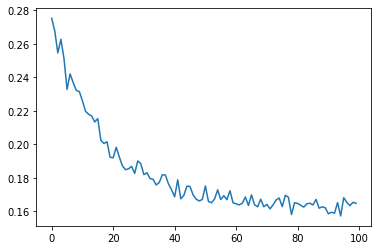

In [0]:
plt.plot(loss_curve)